# 2016-11-25: Support Vector Machines
In this lab, we will apply support vector classification methods to the Endometrium vs. Uterus cancer data. For documentation see: http://scikit-learn.org/0.17/modules/svm.html#svm

Let us start, as usual, by setting up our environment, loading the data, and setting up our cross-validation.

In [2]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load the data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')

In [4]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

## Linear SVM

In [5]:
from sklearn import svm

### SVM decision function

SVMs do not naturally compute probabilities. It is possible to convert the output of the decision function into a probability, but that is a computationally intensive procedure, called Platt's scaling. You can read about it in the corresponding paper: https://www.microsoft.com/en-us/research/publication/probabilities-for-sv-machines/ 

The natural ways for SVMs to return scores (and not predicted classes) is to use the output of their decision function directly.

**Question:** Modify the `cross_validate` function to return as predictions the values of the decision function.

In [6]:
from sklearn import preprocessing

In [7]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        # TODO 
        yte_pred=classifier.decision_function(Xte)
        # Update pred 
        # TODO 
        pred[te] = yte_pred[:]
    return pred

### Linear SVM with default C value

Let us cross-validate an SVM with linear kernel (linear soft-margin SVM) with default C parameter.

In [8]:
clf = svm.SVC(kernel='linear') 
ypred_linear = cross_validate(X, y, clf, folds)

**Question:** Plot the corresponding ROC curve.

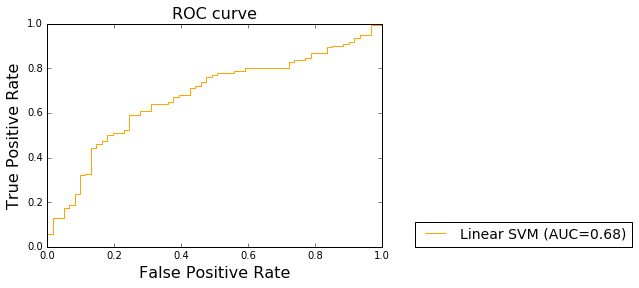

In [9]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, ypred_linear, pos_label=1)# TODO
auc = metrics.auc(fpr, tpr)# TODO

plt.plot(fpr, tpr, '-', #TODO
         color='orange',
         label='Linear SVM (AUC=%.2f)' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

### Number of support vectors

The `n_support_` argument of an svm classifier gives us the number of support vectors for each class.

**Question:** How many support vectors does our classifier have? How many is this compared to the number of training samples?

In [10]:
print(clf.n_support_)
for tr, te in folds:
    continue
len(tr)

[48 58]


165

### Kernel matrix

The kernel matrix is the matrix of size $n \times n$ that has for entry $K_{ij}$ the value $k(x^i, x^j)$, where $k$ is the kernel function used.

In the case of the linear kernel, the kernel function is the dot product.

**Question** Plot the matrix K for the linear kernel.

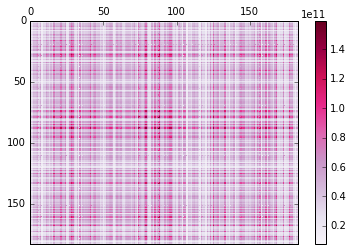

In [14]:
kmatrix = [[sum(X[i][:]*X[j][:]) for j in range(len(X))] for i in range(len(X))]# TODO

# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** What do you observe about the values taken by the kernel? What happens if you scale the data before computing the kernel? 

**Answer** Values taken by the kernel are spread in a wide positive range (0 -> 100_000_000_000)

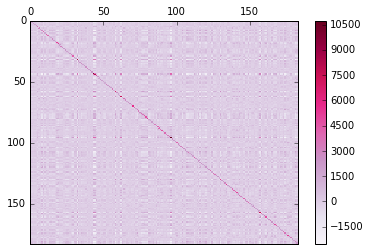

In [15]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
kmatrix = [[sum([X_scaled[i][k]*X_scaled[j][k] for k in range(len(X_scaled[i]))]) for j in range(len(X_scaled))] for i in range(len(X_scaled))]# TODO

# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])
# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

We see the matrice is diagonalised and more homogeanous

**Question:** How does scaling affect the performance of the linear SVM?

In [60]:
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
    
    Scale the training data, and apply same scaling to the test data.
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        scaler = preprocessing.StandardScaler() # create scaler
        Xtr = scaler.fit_transform(Xtr) # fit the scaler to the training data and transform training data
        Xte = scaler.transform(Xte) # transform test data
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        output_decision_function = classifier.decision_function(Xte)
        
        # Update pred
        pred[te] = output_decision_function
        
    return pred

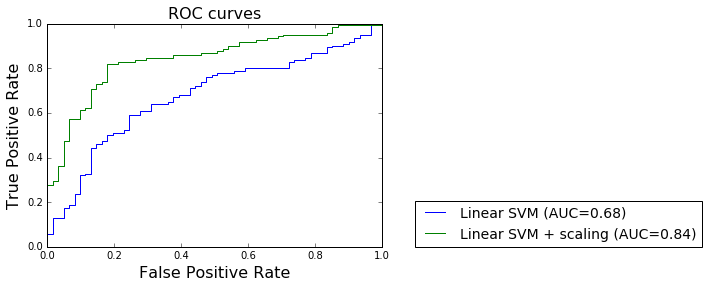

In [61]:
clf = svm.SVC(kernel='linear') 
ypred_linear_scaled = cross_validate_with_scaling(X_scaled, y, clf, folds)

# TODO
fpr_lin_sc,tpr_lin_sc, a = metrics.roc_curve(y, ypred_linear_scaled, pos_label=1)
auc_lin_sc = metrics.auc(fpr_lin_sc, tpr_lin_sc)

plt.plot(fpr, tpr,'-', 
            label='Linear SVM (AUC=%.2f)' % auc)
plt.plot(fpr_lin_sc,tpr_lin_sc, '-', 
            label='Linear SVM + scaling (AUC=%.2f)' % auc_lin_sc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

**Question:** Now optimize for the C-parameter within each loop of the cross-validation. Plot the new ROC curve.

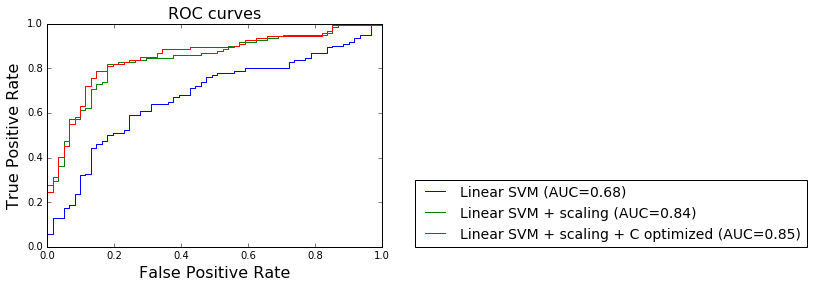

In [62]:
from sklearn import grid_search
parameters_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
# TODO
clf_grid = grid_search.GridSearchCV(svm.SVC(kernel='linear') , 
                               parameters_dict, scoring='roc_auc')


ypred_linear_scaled = cross_validate_with_scaling(X_scaled, y, clf, folds)

ypred_linear_scaled_optimized = cross_validate_with_scaling(X_scaled, y, clf_grid, folds)

# scaled
fpr_lin_sc,tpr_lin_sc, a = metrics.roc_curve(y, ypred_linear_scaled, pos_label=1)
auc_lin_sc = metrics.auc(fpr_lin_sc, tpr_lin_sc)
#optimized
fpr_lin_sc_opt,tpr_lin_sc_opt, a = metrics.roc_curve(y, ypred_linear_scaled_optimized, pos_label=1)
auc_lin_sc_opt = metrics.auc(fpr_lin_sc_opt, tpr_lin_sc_opt)

plt.plot(fpr, tpr,'-', 
            label='Linear SVM (AUC=%.2f)' % auc)
plt.plot(fpr_lin_sc,tpr_lin_sc, '-', 
            label='Linear SVM + scaling (AUC=%.2f)' % auc_lin_sc)
plt.plot(fpr_lin_sc_opt,tpr_lin_sc_opt, '-', 
            label='Linear SVM + scaling + C optimized (AUC=%.2f)' % auc_lin_sc_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

## Polynomial kernels

We will use SVMs with kernels of the form $k(x, x') = (\langle x, x' \rangle + r)^d$.

**Question** Plot kernel matrices for $r=0, d=2$.

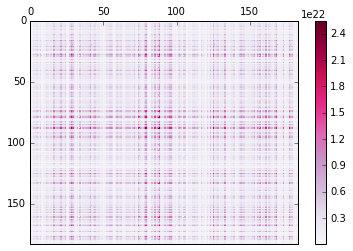

In [19]:
kmatrix = [[sum([X[i][k]*X[j][k] for k in range(len(X[i]))])**2 for j in range(len(X))] for i in range(len(X))]# TODO

# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** What do you observe? What is going to happen if you increase $d$? How do you think this will affect the SVM? Cross-validate the SVM and plot the ROC curve.

Range is higher and more heterogeanous, if we make d hier it will rise this range, and maybe increase the computing time if d is ways too large.


**Sub-Question** Whats the form of the scaled matrice ?

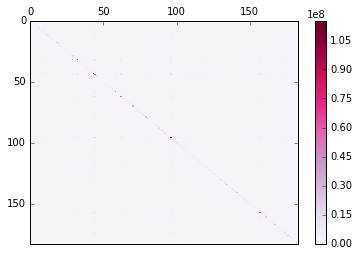

In [21]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
kmatrix = [[sum(X_scaled[i][:]*X_scaled[j][:])**2 for j in range(len(X_scaled))] for i in range(len(X_scaled))]# TODO

# heatmap + color map
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

Aouch, we may have lost some information, the matrice is identity and seems quite poor in significants values

Let's ROC it

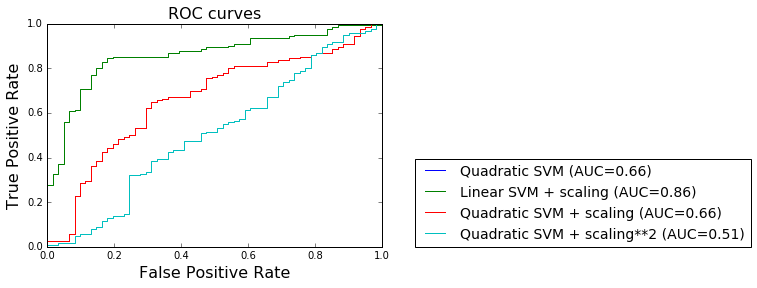

In [22]:
# TODO 
clf_quad = svm.SVC(kernel='poly',degree = 2,coef0 = 0)
ypred_quadratic_pure = cross_validate(X, y, clf_quad, folds)

ypred_quadratic = cross_validate_with_scaling(X, y, clf_quad, folds)

ypred_quadratic_scaled = cross_validate_with_scaling(X_scaled, y, clf_quad, folds)

#pure quadratic
fpr_pure,tpr_pure, a = metrics.roc_curve(y, ypred_quadratic_pure, pos_label=1)
auc_pure = metrics.auc(fpr_pure, tpr_pure)
#quadratic scaled
fpr_quad,tpr_quad, a = metrics.roc_curve(y, ypred_quadratic, pos_label=1)
auc_quad = metrics.auc(fpr_quad, tpr_quad)
#quadratic scaled**2
fpr_quad_sc,tpr_quad_sc, a = metrics.roc_curve(y, ypred_quadratic_scaled, pos_label=1)
auc_quad_sc = metrics.auc(fpr_quad_sc, tpr_quad_sc)

# Plot
plt.plot(fpr_pure,tpr_pure, '-', 
            label='Quadratic SVM (AUC=%.2f)' % auc_pure)
plt.plot(fpr_lin_sc,tpr_lin_sc, '-', 
            label='Linear SVM + scaling (AUC=%.2f)' % auc_lin_sc)
plt.plot(fpr_quad,tpr_quad, 
            label='Quadratic SVM + scaling (AUC=%.2f)' % auc_quad)
plt.plot(fpr_quad_sc,tpr_quad_sc, 
            label='Quadratic SVM + scaling**2 (AUC=%.2f)' % auc_quad_sc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

**Question** What value for $r$ can change this behavior? Plot the corresponding kernel matrix.

In [23]:
"""fig = plt.figure(figsize=(10, 5))
def plotROCs(X,y,folds,clf_str,param_str,tabVals,otherParam):
    lenPlot=len(tabVals)
    w=4
    h=lenPlot//w+1
    for numPlot in range(len(tabVals)):
        clf_str="{}({} = {} ".format(clf_str,param_str,tabVals[numPlot])
        if(len(otherParam)):
            clf_str+=','+otherParam
        clf_str+=")"
        print(clf_str)
        exec("clf="+clf_str)
        ax = fig.add_subplot("{}{}{}".format(w,h,numPlot+1))
        ypred_quadratic_pure = cross_validate(X, y, clf, folds)
        fpr,tpr, a = metrics.roc_curve(y, ypred, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        ax.plt.plot(fpr,tpr, '-', 
                    label=clf_str+' (AUC=%.2f)' % auc_pure)

    ax.plt.xlabel('False Positive Rate', fontsize=16)
    ax.plt.ylabel('True Positive Rate', fontsize=16)
    ax.plt.title('ROC curves', fontsize=16)
    ax.plt.legend(loc=(1.1, 0), fontsize=14)"""

def cross_validate_grid(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
    
    Scale the training data, and apply same scaling to the test data.
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        # Create scaler object
        scaler = preprocessing.StandardScaler()
        # Fit the scaler and transform training data
        scaler.fit_transform(Xtr)
        # Transform test data
        scaler.transform(Xte)
        # Fit classifier
        classifier.fit(Xtr, ytr)
        print(classifier.best_params_)
        yte_pred=classifier.decision_function(Xte)
        pred[te] = yte_pred[:]
    return pred

In [24]:
parameters_dict = {'coef0': [1,1e2,1e4,1e6,1e8]}

# TODO
clf_grid = grid_search.GridSearchCV(svm.SVC(kernel='poly',degree = 2) , 
                               parameters_dict, scoring='roc_auc')

a=cross_validate_grid(X, y, clf_grid, folds)

{'coef0': 1}
{'coef0': 1000000.0}
{'coef0': 1000000.0}
{'coef0': 1000000.0}
{'coef0': 1000000.0}
{'coef0': 100000000.0}
{'coef0': 1000000.0}
{'coef0': 1}
{'coef0': 1}
{'coef0': 1000000.0}


In [66]:
def plotROCs(X,y,folds,clf_str,param_str,tabVals,otherParam,fig,w=1):
    lenPlot=len(tabVals)
    h=lenPlot//w+1
    for numPlot in range(len(tabVals)):
        clf_str_exec="{}({} = {} ".format(clf_str,param_str,tabVals[numPlot])
        if(len(otherParam)):
            clf_str_exec+=','+otherParam
        clf_str_exec+=")"
        print(clf_str_exec)
        exec("clf="+clf_str_exec)
        ax = fig.add_subplot(int("{}{}{}".format(h,w,numPlot+1)))
        ypred = cross_validate_with_scaling(X, y, clf, folds)
        fpr,tpr, a = metrics.roc_curve(y, ypred, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        ax.plot(fpr,tpr, '-', 
                    label='(AUC=%.2f)' % auc)
        plt.legend(loc=(1.1, 0), fontsize=14)
        ax.set_xlabel('False Positive Rate', fontsize=16)
        ax.set_ylabel('True Positive Rate', fontsize=16)
        ax.set_title(clf_str_exec, fontsize=16)

svm.SVC(coef0 = 1 ,kernel='poly',degree = 2)
svm.SVC(coef0 = 100.0 ,kernel='poly',degree = 2)
svm.SVC(coef0 = 10000.0 ,kernel='poly',degree = 2)
svm.SVC(coef0 = 1000000.0 ,kernel='poly',degree = 2)
svm.SVC(coef0 = 100000000.0 ,kernel='poly',degree = 2)


KeyboardInterrupt: 

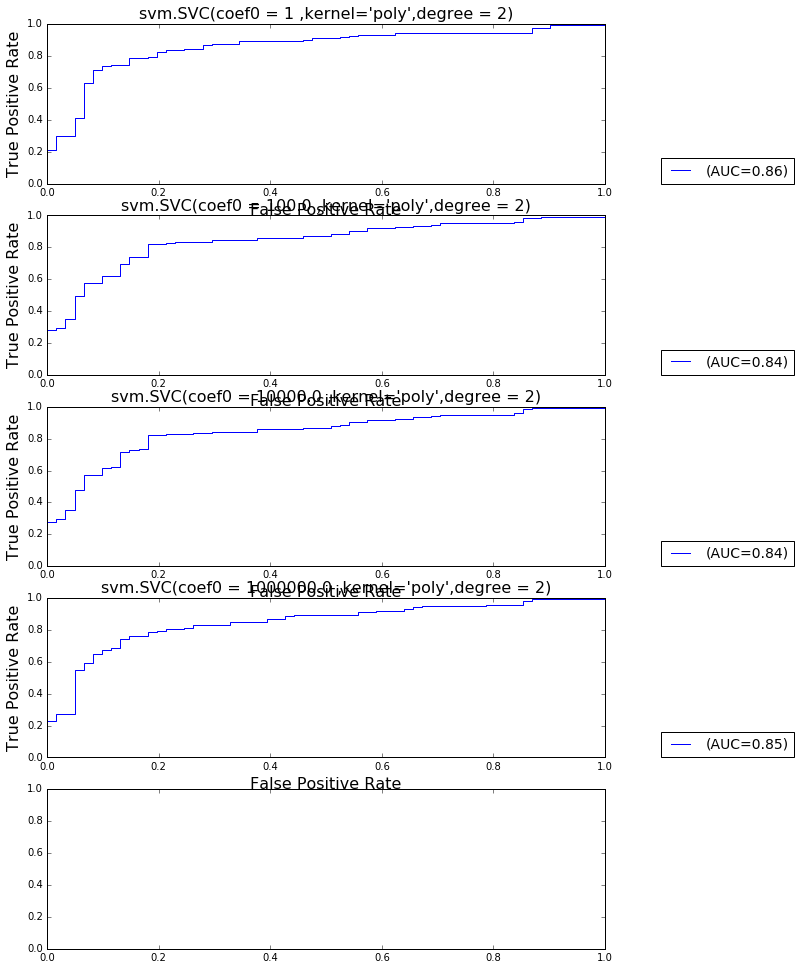

In [68]:
fig = plt.figure(figsize=(10, 20))
#svm.SVC(kernel='poly',degree = 2)
plotROCs(X,y,folds,"svm.SVC",'coef0',[1,1e2,1e4,1e6,1e8],"kernel='poly',degree = 2",fig,1)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 20))
#svm.SVC(kernel='poly',degree = 2)
plotROCs(X,y,folds,"svm.SVC",'degree',[1,2,3],"kernel='poly',coef0 = 1e4",fig,1)
plt.tight_layout()

**Question** Now evaluate an SVM with polynomial kernel of degree d=2 and value for r as above.

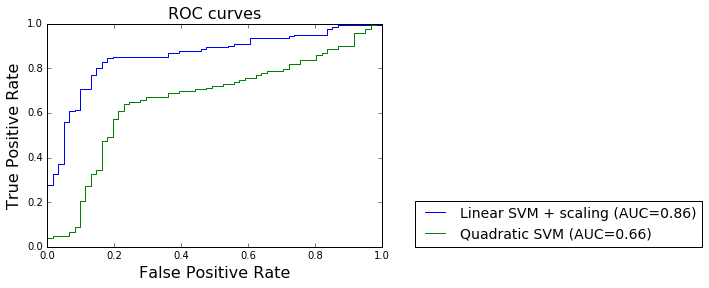

In [54]:
# SVM quadratic with coef0 optimized
clf_quad_r_opt=svm.SVC(kernel='poly',degree = 2, coef0= 1e7)
ypred_quad_r_opt = cross_validate_with_scaling(X, y, clf_quad_r_opt, folds)
fpr_quad_r_opt,tpr_quad_r_opt, a = metrics.roc_curve(y, ypred_quad_r_opt, pos_label=1)
auc_quad_r_opt = metrics.auc(fpr_quad_r_opt, tpr_quad_r_opt)

# Plot
plt.plot(fpr_lin_sc,tpr_lin_sc, #TODO
            label='Linear SVM + scaling (AUC=%.2f)' % auc_lin_sc)
plt.plot(fpr_quad_r_opt,tpr_quad_r_opt, #TODO
            label='Quadratic SVM (AUC=%.2f)' % auc_quad_r_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

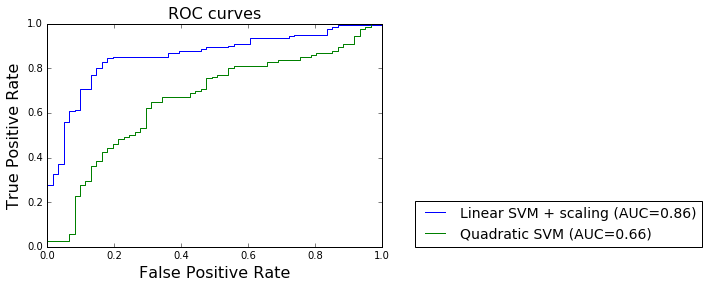

In [55]:
#Adrian one
clf = svm.SVC(kernel='poly',degree = 2,coef0 = 10**4)
ypred_quadratic_2 = cross_validate_with_scaling(X, y, clf, folds)
fpr_quadratic_2, tpr_quadratic_2, thresholds = metrics.roc_curve(y, ypred_quadratic_2, pos_label=1)
auc_quadratic_2 = metrics.auc(fpr_quadratic_2, tpr_quadratic_2)

# Plot
plt.plot(fpr_lin_sc,tpr_lin_sc, #TODO
            label='Linear SVM + scaling (AUC=%.2f)' % auc_lin_sc)
plt.plot(fpr_quadratic_2, tpr_quadratic_2,
            label='Quadratic SVM (AUC=%.2f)' % auc_quadratic_2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc=(1.1, 0), fontsize=14)

## Gaussian RBF kernels

We will use SVMs with kernels of the form $k(x, x') = \exp \left(-\gamma ||x - x'||^2 \right)$.

The following code efficiently computes the pairwise squared distances between all items in X, that is to say the matrix $P$ such that $P_{ij} = ||x^i - x^j||^2$.

In [56]:
from scipy.spatial.distance import pdist, squareform
pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))

**Question** Plot kernel matrices for varying values of $\gamma$. What do you observe? What is going to be the impact on the SVM? What happens with very very small values of $\gamma$? Check your intuitions by cross-validating SVMs with these various kernels.

1e-12


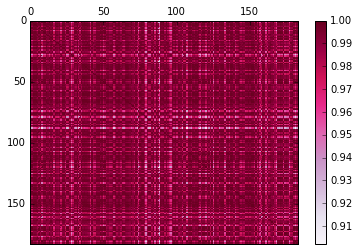

1e-11


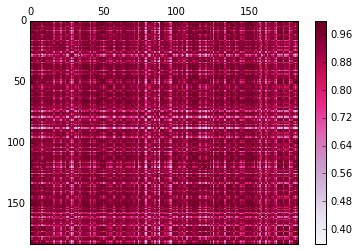

1e-10


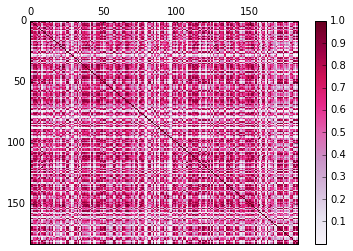

1e-09


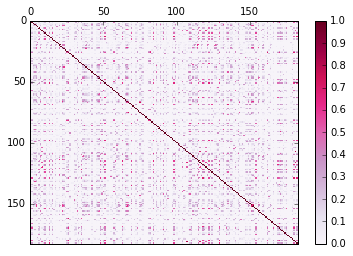

1e-08


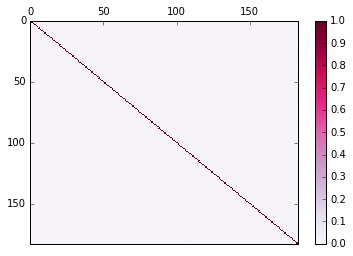

1e-07


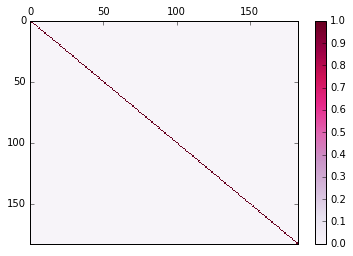

In [57]:
for gamma in [10**i for i in range(-12,-6,1)]:
    print(gamma)
    kmatrix = [[np.exp(-gamma*pairwise_sq_dists[i][j]) for j in range(len(X))] for i in range(len(X))]# TODO

    # heatmap + color map
    plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

    # plot colorbar to the right
    plt.colorbar()

    # set axes boundaries
    plt.xlim([0, X.shape[0]])
    plt.ylim([0, X.shape[0]])

    # flip the y-axis
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    plt.show()

svm.SVC(gamma = 1e-08 ,kernel='rbf')
svm.SVC(gamma = 1e-07 ,kernel='rbf')
svm.SVC(gamma = 1e-06 ,kernel='rbf')
svm.SVC(gamma = 1e-05 ,kernel='rbf')
svm.SVC(gamma = 0.0001 ,kernel='rbf')
svm.SVC(gamma = 0.001 ,kernel='rbf')


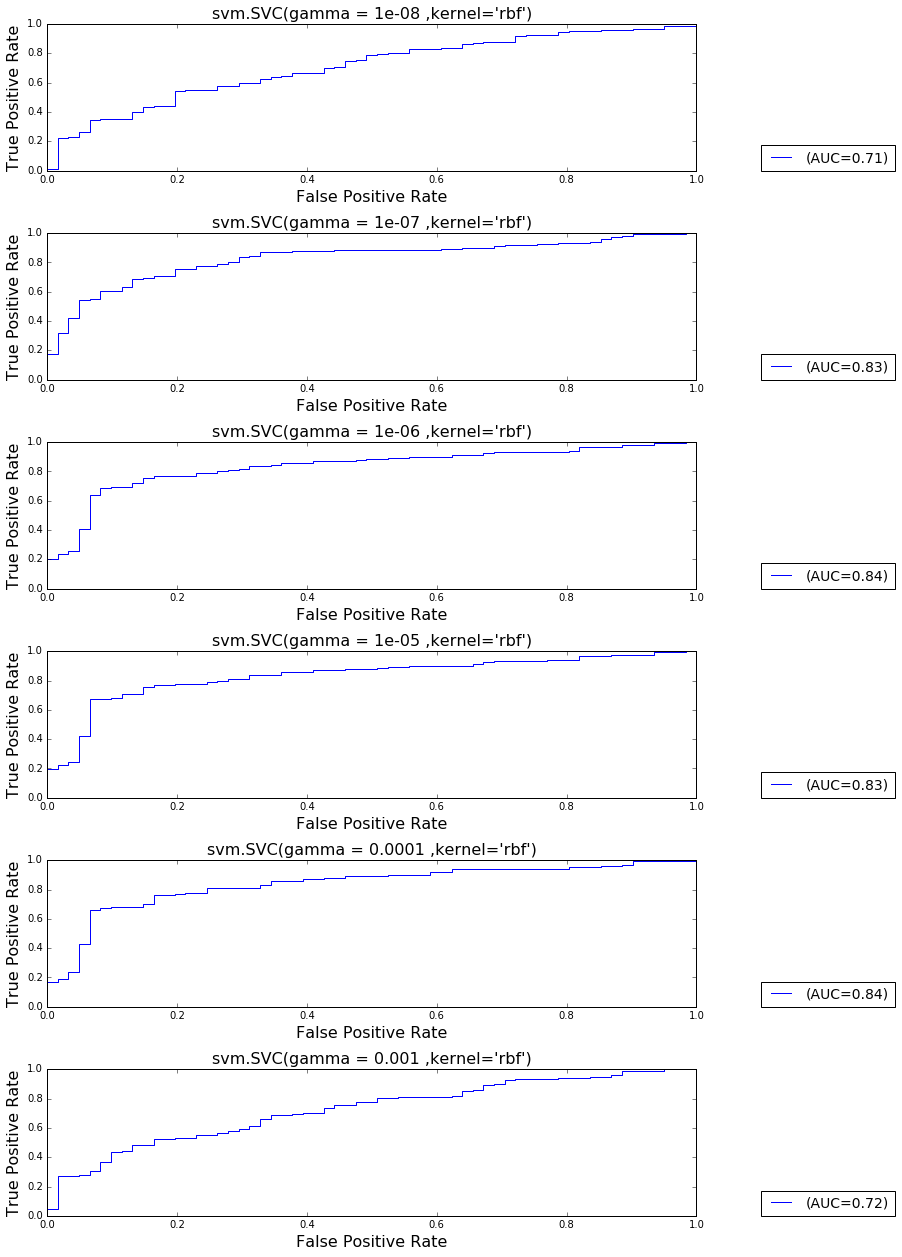

In [115]:
fig = plt.figure(figsize=(10, 20))
#svm.SVC(kernel='poly',degree = 2)
plotROCs(X,y,folds,"svm.SVC",'gamma',[10**i for i in range(-8,-2,1)],"kernel='rbf'",fig,1)
plt.tight_layout()

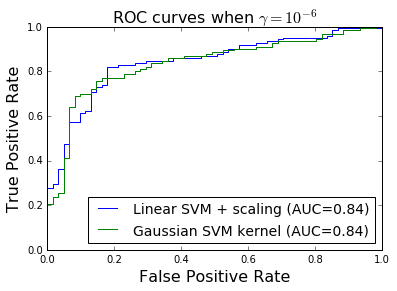

In [65]:
clf = svm.SVC(kernel='rbf',gamma = 1e-6
ypred_rbf = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf, tpr_rbf, thresholds = metrics.roc_curve(y, ypred_rbf, pos_label=1)
auc_rbf = metrics.auc(fpr_rbf, tpr_rbf)

plt.plot(fpr_lin_sc, tpr_lin_sc,
            label='Linear SVM + scaling (AUC=%.2f)' % auc_lin_sc)
plt.plot(fpr_rbf, tpr_rbf,
            label='Gaussian SVM kernel (AUC=%.2f)' % auc_rbf)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves when $\gamma = 10^{-6}$', fontsize=16)
plt.legend(loc = 4, fontsize=14)

## (Bonus) Scaling the kernel matrix.

What we have observed here is a phenomenon of diagonal dominance in the kernel matrix. 

One way to address this is to re-scale the kernel matrix in the following way:
$\hat K_{ij} = \frac{K_{ij}}{\sqrt{K_{ii} K_{jj}}}$.

To implement this you can pass your own kernel function or matrix to the `kernel` parameter of the SVM.

**Question:** Write a function `scaled_quadratic_kernel` that computes the scaled quadratic kernel matrix between two data arrays.

In [162]:
from scipy.spatial.distance import sqeuclidean
def scaled_quadratic_kernel(X1, X2):
    
    """ Custom scaled RBF kernel.
    
    The RBF kernel between X1 and X2 is scaled to avoid diagonal dominance,
    by applying k(X1i, X2j) <-- k(X1i, X2j) / sqrt(k(X1i, X1i) k(X2j, X2j))   
   
    Parameters:
    -----------
    X1: (n_samples1, n_features) np.array
        First data matrix.
    X2: (n_samples2, n_features) np.array
        Second data matrix.
        
    Return:
    -------
    K: (n_samples1, n_samples2) np.array
        Kernel matrix between samples from X1 and samples from X2.
    """
    #k=lambda x:np.exp(-gamma*x)
    gamma=1e-6
    k=lambda x:np.exp(-gamma*x)
    X1_X2_dist=lambda x,y:sqeuclidean(X1[x][:],X2[y][:])#squareform(cdist(X1,X2, 'sqeuclidean'))
    X1_X1_dist=squareform(pdist(X1, 'sqeuclidean'))
    X2_X2_dist=squareform(pdist(X2, 'sqeuclidean'))
    K=np.zeros((len(X1),len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            K[i][j]=k(X1_X2_dist(i,j))/np.sqrt(k(X1_X1_dist[i][i]+X2_X2_dist[j][j]))
    return K


**Question:** Plot the corresponding kernel matrix. Does it match your expectations?

[[  1.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   1.00000000e+000   0.00000000e+000 ...,
    4.09375909e-291   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   1.00000000e+000 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 ..., 
 [  0.00000000e+000   4.09375909e-291   0.00000000e+000 ...,
    1.00000000e+000   0.00000000e+000   4.20553563e-302]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    0.00000000e+000   1.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    4.20553563e-302   0.00000000e+000   1.00000000e+000]]


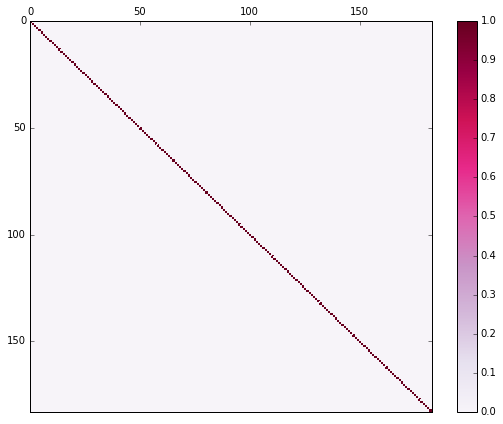

In [163]:
kmatrix_scaled = scaled_quadratic_kernel(X,X)
print(K)

np.savetxt("kmatrix_scaled",kmatrix_scaled,delimiter=",")
#Plot
fig = plt.figure(figsize=(9, 7))
# heatmap + color map
plt.pcolor(kmatrix_scaled, cmap=matplotlib.cm.PuRd) 

# plot colorbar to the right
plt.colorbar()

# set axes boundaries
plt.xlim([0, X.shape[0]])
plt.ylim([0, X.shape[0]])

# flip the y-axis
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

**Question:** In the 0.17 version of scikit-learn, it isn't possible to use a custom kernel function within GridSearchCV. Set the C parameter to 1 and compare your custom kernel with the quadratic kernel (d=2) on the gene expression data.

In [164]:
clf = svm.SVC(kernel='rbf',gamma = 10**(-6))
ypred_rbf = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf, tpr_rbf, thresholds = metrics.roc_curve(y, ypred_rbf, pos_label=1)
auc_rbf = metrics.auc(fpr_rbf, tpr_rbf)

clf = svm.SVC(kernel=scaled_quadratic_kernel, gamma = 10**(-6))
ypred_rbf_2 = cross_validate_with_scaling(X, y, clf, folds)
fpr_rbf_2, tpr_rbf_2, thresholds = metrics.roc_curve(y, ypred_rbf_2, pos_label=1)
auc_rbf_2 = metrics.auc(fpr_rbf_2, tpr_rbf_2)

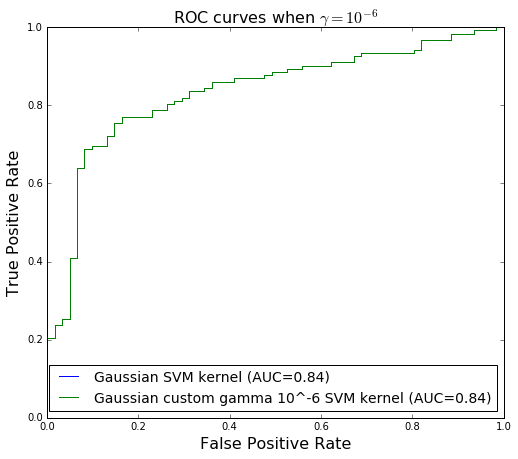

In [165]:
#2 subplots
fig = plt.figure(figsize=(18, 7))

# Plot 1
fig.add_subplot(121) # 2 x 2 grid

#plt.plot(fpr_linear_scaled, tpr_linear_scaled,
#            label='Linear SVM + scaling (AUC=%.2f)' % auc_linear_scaled)
plt.plot(fpr_rbf, tpr_rbf,
            label='Gaussian SVM kernel (AUC=%.2f)' % auc_rbf)
plt.plot(fpr_rbf_2, tpr_rbf_2,
            label='Gaussian custom gamma 10^-6 SVM kernel (AUC=%.2f)' % auc_rbf_2)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves when $\gamma = 10^{-6}$', fontsize=16)
plt.legend(loc = 4, fontsize=14)